## Sinkhorn bridges via POT

We first write a function that extracts the potentials that solve the static Sinkhorn problem defined on the samples, which will later define the drift.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from toydatasets import *

plt.rcParams.update({'font.size': 20})

import ot

def sinkhorn_potentials(source,target,eps,dim,n,iters_max=2000):
    a, b = np.ones((n,)) / n, np.ones((n,)) / n 
    M = ot.dist(source.T, target.T)/2.
    _,log_ = ot.sinkhorn(a, b, M, eps,method='sinkhorn_log',log=True, stopThr=5e-4,
                                            numItermax=iters_max,print_period=50)
        
    logv_opt = log_['log_v']
    logu_opt = log_['log_u']
    return logu_opt, logv_opt

## Sinkhorn bridge between 2D toy datasets

The 2D toy datasets function includes the following options: 'checkerboard', 'swissroll', 'circles', 'rings', 'moons', '8gaussians', 'pinwheel', and '2spirals'.

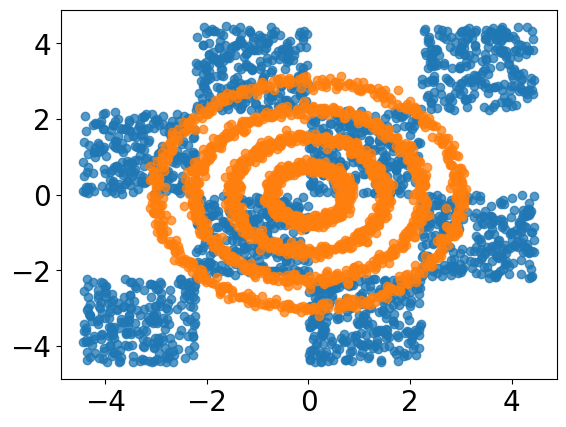

In [3]:
dim = 2
Ntrain = 2000

source_name = 'rings'
target_name = 'checkerboard'

source = ToyDatasets(source_name)  
target = ToyDatasets(target_name)

xdata = source.sample_joint(Ntrain)
ydata = target.sample_joint(Ntrain)

plt.scatter(ydata[:,0],ydata[:,1],alpha=0.75)
plt.scatter(xdata[:,0],xdata[:,1],alpha=0.75)

We now compute the potentials defined on the in-sample target points, which will be stored and used in the drift. This is also where we set the base regularization parameter $\varepsilon > 0$ which governs the overall shape of the bridge. 

In [4]:
eps = 0.1
_, geps_over_eps = sinkhorn_potentials(xdata.T,ydata.T,eps,dim,Ntrain,iters_max=10000)

## Defining the drift

The drift that defines the Sinkhorn bridge hinges on the fitted potentials $(\hat{f},\hat{g})$ that solve the static problem. Here we express the drift succinctly as a function of the target sample points and $\hat{g}$, and use to extend the function to a batch of inputs. Note that 'eps' has to be the same parameter as the one used to compute the fitted potentials.

In [5]:
class ent_drift():
    def __init__(self, data, potential, eps):
        self.data = data
        self.potential = potential
        self.eps = eps

    def estimator(self,x,t):
        M = ot.dist(x,self.data)/(2*t)
        K = -M/self.eps + self.potential
        gammaz = -np.max(K,axis=1)
        K_shift = K + gammaz.reshape(-1,1)
        exp_ = np.exp(K_shift)
        top_ = exp_ @ self.data
        bot_ = exp_.sum(axis=1)
        drift_without_x = top_/bot_.reshape(-1,1)

        return (-x + drift_without_x)/(t)
    
    def __call__(self, x, t):
        return self.estimator(x, t)

Then we initialize at new points, and run a standard Euler--Maruyama discretization of the SDE. The hyperparameters, namely 'tau' and 'Nsteps' can be varied as needed. The parameter 'tau' denotes how long along the bridge we want to traverse, and 'Nsteps' denotes the number of steps that will be taken to appropriately discretize the trajectory.

We then draw 'Ntest' many new points from the source distribution, and iterate over the Euler--Maruyama dynamics defined with respect to the above drift function.

In [6]:
tau = 0.9
Nsteps = 50

Ntest = 5000

xinit = np.array(source.sample_joint(Ntest))
dt = tau/Nsteps
k=0
t=0.0

x = xinit.copy()

xiters = np.zeros((Nsteps+1,xinit.shape[0],xinit.shape[1]))
xiters[0] = x

drift_estimator = ent_drift(ydata,geps_over_eps,eps)
while k < Nsteps:
    bteps_x = drift_estimator(x,1-t)
    eta = np.random.multivariate_normal(np.zeros(dim), np.eye(dim), size=xinit.shape[0])
    x += (dt * bteps_x) + np.sqrt(dt * eps)*eta
    k += 1
    t = k*dt
    xiters[k] = x

The following cell generates plots across the time marginals.

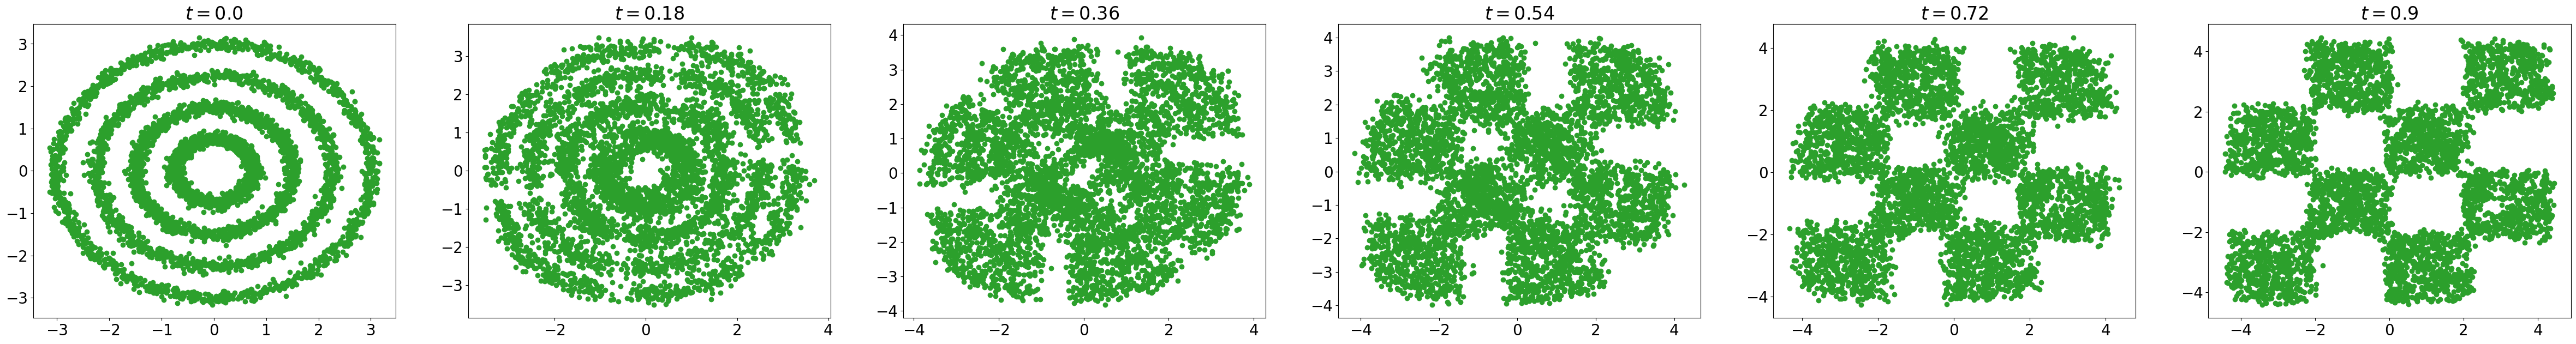

In [7]:
Nsplits = 5
jump = int(Nsteps/Nsplits)
fig, axs = plt.subplots(1, Nsplits+1, figsize=(60, 7))
j = 0

for i in range(Nsplits+1):
    j = min(i*jump,Nsteps)
    axs[i].scatter(xiters[j,:,0],xiters[j,:,1],c='#2ca02c')
    tcur = round(j/Nsteps * tau, 2)
    axs[i].set_title(r'$t={}$'.format(tcur)) 
plt.savefig('from_{}_to_{}_POT.png'.format(source_name,target_name),format='png',dpi=300)